In [10]:
import pandas as pd
import numpy as np
import math
import networkx as nx
%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
import heapq
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
import itertools
import pickle

In [11]:
############################################  read the data ####################################################
artists_data =pd.read_csv('F:/Projects/PGM/Music Recommendation/artists.csv',encoding = "ISO-8859-1")
user_artist_data =pd.read_csv('F:/Projects/PGM/Music Recommendation/user_artists.csv', encoding = "ISO-8859-1")
tags_data =pd.read_csv('F:/Projects/PGM/Music Recommendation/tags.csv', encoding = "ISO-8859-1")
user_friends_data =pd.read_csv('F:/Projects/PGM/Music Recommendation/user_friends.csv', encoding = "ISO-8859-1")
user_taggedartists =pd.read_csv('F:/Projects/PGM/Music Recommendation/user_taggedartists.csv', encoding = "ISO-8859-1")




In [12]:
######################### remove users with only one listened artist
users = np.unique(user_artist_data['userID'])
to_rem = list()
for usr in users:
    if( len(user_artist_data.loc[(user_artist_data.userID == usr),['artistID']]) == 1 ):
        to_rem.append(usr)


user_artist_data = user_artist_data[(user_artist_data.userID.isin(to_rem) ) == False]

In [13]:
###################### Convert the implicit play counts into explicit ratings ######################################
##################### and divide the user-artist data into training and test sets ##################################
user_artist_train = pd.DataFrame()
user_artist_test = pd.DataFrame()

for usr in users:
   temp_df = user_artist_data.loc[(user_artist_data.userID == usr),['userID','artistID','weight']] 
   if(len(temp_df) >  1):
       wts = np.asarray(temp_df['weight'])
       wts_scaled = np.zeros(len(wts))
       wts_scaled.astype(float)
       wt_max = np.max(wts)
       wt_min = np.min(wts)
       if(wt_max == wt_min):
           for i in range(0,len(temp_df)):
              wts_scaled[i] = 1           
       else:    
           for i in range(0,len(temp_df)):
              wts_scaled[i] = (wts[i]-wt_min)/(wt_max - wt_min)
              
       if(math.isnan(wts_scaled[i])):
              print (usr)
       temp_df['weight_scaled'] = wts_scaled
       temp_train, temp_test = train_test_split(temp_df,test_size=0.40, random_state=1)
       user_artist_train = user_artist_train.append(temp_train)
       user_artist_test = user_artist_test.append(temp_test)

user_artist_train.index = range(len(user_artist_train))
user_artist_test.index = range(len(user_artist_test))

In [14]:
########################################### Initialize the empty graph ###########################################
soc_graph = nx.Graph() 



In [15]:
################################## create nodes  for artists and users and add to the graph ########################

########## create nodes for users
user_nodes = ["user_" + str(i) for i in users]
user_nodes = pd.DataFrame(user_nodes,index = users)
user_nodes = user_nodes.rename(columns = {0:'n'})

########## add user nodes to the graph
for i in users:
   soc_graph.add_node(user_nodes['n'][i])


########## create nodes for the artists
artists  = np.unique(user_artist_data['artistID'])
artists = artists.astype(int)
artist_nodes = ["artist_" + str(i) for i in artists]
artist_nodes = pd.DataFrame(artist_nodes,index = artists)
artist_nodes = artist_nodes.rename(columns = {0:'n'})


########## add artist nodes to the graph
for i in artists:
   soc_graph.add_node(artist_nodes['n'][i])

In [23]:
######################### Connect the users to the artists and assign weights #####################################

################## connect users to artists whom they have listened to
for i in range(0,len(user_artist_train)):
    usr = user_artist_train['userID'][i]
    art = user_artist_train['artistID'][i]
    wt =  user_artist_train['weight_scaled'][i]
    soc_graph.add_edge((user_nodes['n'][usr]),(artist_nodes['n'][art]),weight = wt)
 

In [ ]:
############################# Connect the related users in the social graph and assign weights ##################### 

############## collect the tags data  for individual users
user_tags_list = []

for usr in users:
    temp = user_taggedartists.loc[(user_taggedartists.userID == usr), ['userID', 'tagID']]
    temp_list = list()
    for i in temp.ix[:,1]:
        temp_list.append(i)
        
    user_tags_list.append(temp_list)
   
user_tags = pd.DataFrame(index = users)
user_tags['tags'] =user_tags_list



############## collect the artist-weight  data  for individual users
user_art_wts = [dict() for x in range(len(users))]
artist_weights = pd.DataFrame()
artist_weights['Dict'] = user_art_wts
artist_weights = artist_weights.set_index(users)

for usr in users:
    temp = pd.DataFrame(user_artist_train.loc[(user_artist_train.userID == usr), ['artistID', 'weight']])
    temp.index = range(len(temp))
    for i in range(0,len(temp)):
        artist_weights.ix[usr,0][temp['artistID'][i]] = temp['weight'][i] 
        
  

 ############## compute similarity between the users and connect 
i = 1
for usr1 in users:
   for usr2 in users[i:len(users)]:
      arr1 = user_tags.ix[usr1,0]
      arr2 = user_tags.ix[usr2,0]
      common = np.intersect1d(arr1,arr2)  ###### similarity based on co-tagging behavior    
      if( len(common) != 0 ):
          usr1_count = np.fromiter(iter({x:arr1.count(x) for x in common}.values()), dtype=int)
          usr2_count = np.fromiter(iter({x:arr2.count(x) for x in common}.values()), dtype=int)
          wt_tag = cosine_similarity(usr1_count,usr2_count)
      else:
          wt_tag = 0
     
      arr1 = artist_weights.ix[usr1,0]
      arr2 = artist_weights.ix[usr2,0]
      common = list(set(arr2).intersection(arr1))  ###### similarity based on listned artists
      if(len(common) != 0):
         wt1 = [arr1[x] for x in common]
         wt2 = [arr2[x] for x in common]
         wt_listn = cosine_similarity(wt1,wt1)
      else:
         wt_listn = 0 
      
      avg_wt = float((wt_tag + wt_listn)/2 )
      if(avg_wt > 0):
          soc_graph.add_edge((user_nodes['n'][usr1]),(user_nodes['n'][usr2]),weight = avg_wt  )
          
   i = i +1  
                

In [ ]:
########################################## determine if the graph is connected ##################################
nx.is_connected(soc_graph)
nx.number_connected_components(soc_graph)

######## save the original graph
pickle.dump(soc_graph, open('F:/Projects/PGM/Music Recommendation/orig_graph.txt', 'wb'))    

###### get the connected compoents
conn_comps = sorted(nx.connected_components(soc_graph), key = len, reverse=True)


####### if the graph is not connected get the largest conencted component
if not nx.is_connected(soc_graph):
    # get a list of unconnected networks
    sub_graphs = nx.connected_component_subgraphs(soc_graph)
    sub_graphs = list(sub_graphs)
    main_graph = sub_graphs[0]

    # find the largest network in that list
    for sg in sub_graphs:
        if len(sg.nodes()) > len(main_graph.nodes()):
            main_graph = sg
    
    soc_graph = main_graph


pickle.dump(soc_graph, open('F:/Projects/PGM/Music Recommendation/graph2.txt', 'wb'))  


In [16]:
soc_graph = pickle.load(open('F:/Projects/PGM/Music Recommendation/graph2.txt','rb'))


In [17]:
soc_graph.number_of_edges()

1172239

In [24]:
###### create a color list for nodes 
color_list = list()
for name in soc_graph.nodes():
   if("user" in name):
     color_list.append(1)
   else:
     color_list.append(0)

In [28]:
spring_pos = nx.spring_layout(soc_graph)

<IPython.core.display.Javascript object>


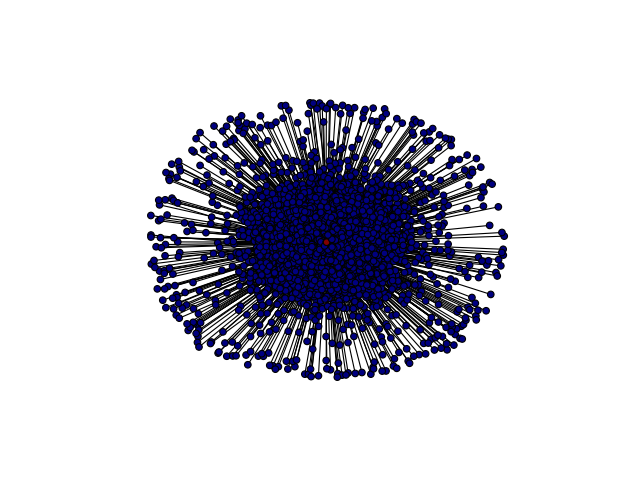

In [29]:
plt.axis("off")
nx.draw_networkx(soc_graph, pos = spring_pos, with_labels = False, node_size = 35,node_color = color_list)

In [30]:
########Quick snapshot of the Network
print (nx.info(soc_graph))

Name: 
Type: Graph
Number of nodes: 12835
Number of edges: 1172239
Average degree: 182.6629


In [32]:
########################## Compute the adjacency matrix 
adj_matrix = nx.adjacency_matrix(soc_graph)
adj_matrix = adj_matrix.todense()


######################### get the column normalized adjacency matrix
adj_matrix_norm = normalize(adj_matrix, norm='l1', axis=0)

In [ ]:
###################################### Random Walk with restarts #################################################

a = 0.9 ##### restart probability

users_test = np.unique(user_artist_test['userID'])
users_test  = users_test .astype(int)
users_test = np.setdiff1d(users_test,np.array([1893]))  #####remove the users not in the largest connected component 

succ_1 = 0
succ_5 = 0
succ_10 = 0
succ_20 = 0

top_1 = np.zeros(len(users_test))
top_5 = np.zeros(len(users_test))
top_10 = np.zeros(len(users_test))
top_20 = np.zeros(len(users_test))

############# iterate over all the cases in the test set
k = 0
for user in users_test:
   p = np.matrix((1/len(adj_matrix)) * np.ones(len(adj_matrix)))  ###### starting probability distributions of the nodes
   p = np.reshape(p,(len(adj_matrix),1))
   num = np.where(np.asarray(soc_graph.nodes()) == user_nodes['n'][user])[0][0]
   q = np.matrix(np.zeros(len(adj_matrix)))
   q = np.reshape(q,(len(adj_matrix),1))
   q[num] = 1


    ################ start the random walk with restart
   for i in range(0,20):
      p1 = p
      p = (1-a) * adj_matrix_norm * p + a * q
    
    #np.max(abs(p1-p))

   p_arr = np.squeeze(np.asarray(p))
   top_el = heapq.nlargest(18400, range(len(p_arr)), p_arr.take)

   result = list()
   for i in top_el:
      result.append(soc_graph.nodes()[i])

   train_artists = np.squeeze(np.array(user_artist_train.loc[(user_artist_train.userID == user), ['artistID']]))

   seen_artists = list()
   if(len(np.atleast_1d(train_artists)) > 1):
     for i in train_artists:
       seen_artists.append(artist_nodes['n'][i])
   elif(len(np.atleast_1d(train_artists)) == 1):
     seen_artists.append(artist_nodes['n'][int(train_artists)])


   artist_list = artist_nodes.values.T.tolist() 
   artist_list2 = list(itertools.chain.from_iterable(artist_list)) 

   recom_artists = list()
   for i in result:
       if( ( (i in seen_artists) == False) and ( (i in artist_list2) == True)):
          recom_artists.append(i)
   recom_artists = np.asarray(recom_artists)

   usr_art = np.asarray(user_artist_test.loc[(user_artist_test.userID == user),['artistID']])
   usr_art = usr_art.astype(int)
   usr_art = np.asarray(np.squeeze(usr_art))
     
   artist_usr = list()
   if(len(np.atleast_1d(usr_art)) > 1):
     for i in usr_art:
       artist_usr.append(artist_nodes['n'][i])
   else:
       artist_usr.append(artist_nodes['n'][int(usr_art)])
   artist_usr = np.asarray(np.squeeze(artist_usr))    
       
   
   top_1[k] = len(np.intersect1d(recom_artists[0:1],artist_usr)) 
   top_5[k] = len(np.intersect1d(recom_artists[0:5],artist_usr)) 
   top_10[k] = len(np.intersect1d(recom_artists[0:10],artist_usr)) 
   top_20[k] = len(np.intersect1d(recom_artists[0:20],artist_usr)) 
   
   
   if( top_1[k] != 0):
       succ_1 = succ_1 + 1
       succ_5 = succ_5 + 1
       succ_10 = succ_10 + 1
       succ_20 = succ_20 + 1
   elif( top_5[k] != 0):
       succ_5 = succ_5 + 1
       succ_10 = succ_10 + 1
       succ_20 = succ_20 + 1
   elif(top_10[k] != 0):
       succ_10 = succ_10 + 1
       succ_20 = succ_20 + 1
   elif( top_20[k] != 0):
       succ_20 = succ_20 + 1  
   
   k = k+1

<IPython.core.display.Javascript object>


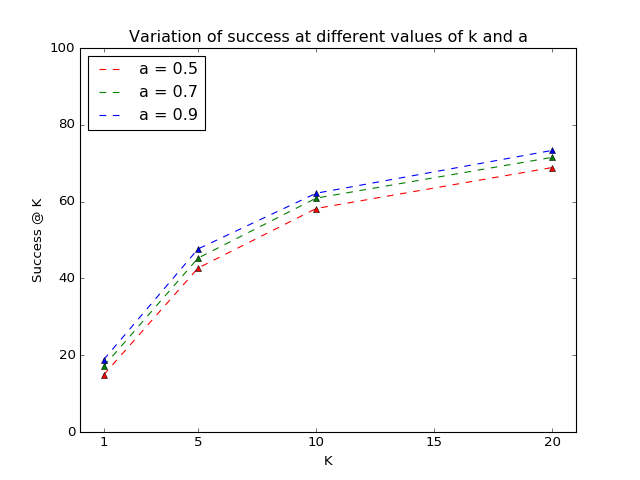

In [107]:
f = plt.figure(3)
ymax = 100
plt.ylim(0, ymax)
plt.xlim(0,21)
plt.xlabel('K')
plt.ylabel('Success @ K')
plt.title('Variation of success at different values of k and a')


##### success @ k as a function of the value of k (a=0.5)
plt.plot([1,5,10,20],[14.86,42.7,58.2,68.88],'r--',label = 'a = 0.5')
plt.plot([1,5,10,20],[14.86,42.7,58.2,68.88],'r^')

##### success @ k as a function of the value of k (a=0.7)
plt.plot([1,5,10,20],[17.1,45.3,60.91,71.53],'g--',label = 'a = 0.7')
plt.plot([1,5,10,20],[17.1,45.3,60.91,71.53],'g^')

##### success @ k as a function of the value of k (a=0.9)
plt.plot([1,5,10,20],[18.82,47.68,62.18,73.34],'b--',label = 'a = 0.9')
plt.plot([1,5,10,20],[18.82,47.68,62.18,73.34],'b^')

plt.xticks(list([1,5,10,15,20]))
plt.legend(loc='upper left')


f.show()

<IPython.core.display.Javascript object>


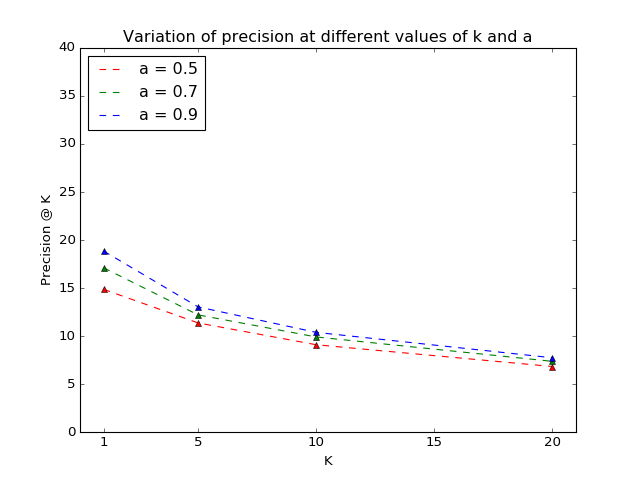

In [106]:
f = plt.figure(4)
ymax = 40
plt.ylim(0, ymax)
plt.xlim(0,21)
plt.xlabel('K')
plt.ylabel('Precision @ K')
plt.title('Variation of precision at different values of k and a')


##### precision @ k as a function of the value of k (a=0.5)
plt.plot([1,5,10,20],[14.86,11.36,9.09,6.82],'r--',label = 'a = 0.5')
plt.plot([1,5,10,20],[14.86,11.36,9.09,6.82],'r^')

##### precision @ k as a function of the value of k (a=0.7)
plt.plot([1,5,10,20],[17.1,12.2,9.9,7.36],'g--',label = 'a = 0.7')
plt.plot([1,5,10,20],[17.1,12.2,9.9,7.36],'g^')

##### precision @ k as a function of the value of k (a=0.9)
plt.plot([1,5,10,20],[18.85,13.03,10.38,7.73],'b--',label = 'a = 0.9')
plt.plot([1,5,10,20],[18.85,13.03,10.38,7.73],'b^')

plt.xticks(list([1,5,10,15,20]))
plt.legend(loc='upper left')

f.show()